# Obligatorio - Taller Agentes Inteligentes


El objetivo es resolver los dos siguientes problemas utilizando Deep Q Learning y Double Deep Q Learning, comparando sus resultados:

1.   MountainCar-v0: El espacio de observacion es de 2 (posicion y velocidad) y el número de acciones posibles es 3. https://gym.openai.com/envs/MountainCar-v0/.


2.   CartPole-v1: El espacio de observacion es de 4 (posicion, velocidad, ángulo, velocidad en el tope) y el número de acciones posibles es 2. https://gym.openai.com/envs/CartPole-v1/. El ambiente termina si el péndulo se cae o se llegan a los 500 steps.


## Tareas:


1. Completar el código faltante en este notebook.


2. Entrenar un agente de Deep Q Learning (DQN) para cada ambiente tal que éste sea capaz de resolverlo.


3. Entrenar un agente de Double Deep Q Learning (DDQN) para cada ambiente tal que éste sea capaz de resolverlo.


4. Graficar las recompensas obtenidas para cada ambiente por cada agente (Ambos agentes resolviendo MountainCar en una misma gráfica, idem para CartPole). Escribir al menos 2 conclusiones de cada grafica. 


5. Grabar un video de cada agente resolviendo cada problema (pueden descargar el video desde colab y entregarlos dentro de un zip).


***


Fecha de entrega: **Lunes 6 de Julio**. Pueden trabajar en grupos de hasta 3 estudiantes. Recuerden que pueden usar la GPU en google colab para agilizar el entrenamiento. 

## Dependencias y funciones para mostrar video en Colab

Igual que en el laboratorio de diferencias temporales, les damos las funciones necesarias para que trabajen con videos en Colab. Se usan de la misma forma que las usamos en el laboratorio.

In [12]:
# Dependencias necesarias.
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

 # Imports y funciones para ver el ambiente.
import io
import gym
import glob
import base64
from gym.wrappers import Monitor
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay


display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
    """
    Utility function to enable video recording of gym environment and displaying it
    To enable video, just do "env = wrap_env(env)""
    """
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    """
    Wrapper del ambiente donde definimos un Monitor que guarda la visualizacion como un archivo de video.
    """

    env = Monitor(env, './video', force=True)
    return env

# Imports necesarios, configuracion de semilla y uso de GPU


In [2]:
import gym
import math
import torch
import random
import numpy as np
from PIL import Image
from torchvision import transforms

from tqdm.notebook import tqdm
from collections import namedtuple
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Running on {DEVICE}")

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

Running on cuda:0


# Deep Q Learning


Recomendamos empezar implementando Deep Q Learning (paper presentado por DeepMind. Pueden encontrar el mismo en arxiv: https://arxiv.org/pdf/1312.5602.pdf).

***

En las celdas siguientes dejamos el código que deben implementar asi como una explicación del mismo.

# Memoria

El algoritmo de Deep Q Learning presentado en el paper utiliza una memoria (llamada Replay Memory) para almacenar transiciones pasadas. Tuplas que contienen un estado base, la accion tomada, la recompensa obtenida, una bandera que indica si el siguiente estado es final o no; y el estado siguiente.

Esta memoria es circular, es decir, tiene un límite maximo de elementos y una vez esté llena comienza a reemplazar los elementos más viejos.

Vamos a necesitar crear una función **sample** que obtiene una mustra aleatoria de elementos de la memoria.  Esto puede ser una lista de Transiciones o listas separadas (pero alineadas) de los elementos que las componen.


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'done', 'next_state'))

# Ejemplo uso
# nueva_tupla = Transition(state, action, reward, done, next_state)

#Se utiliza esta clase para muestrear de acciones pasadas y entrenar al modelo
#utilizando estos estados pasados. La replay memory es esencial para romper
#la correlación lineal entre muestras. Sin replay memory, el modelo nunca 
#revaluaría estados pasados y quedaría trancado en un mínimo local.

class ReplayMemory:

    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.memory = []
        self.position = 0

    def add(self, state, action, reward, done, next_state):
      # Creo la transición a guardar en memoria
      transicion_a_guardar = Transition(state, action, reward, done, next_state)
      #Si tengo lugar en memoria, guardo la transición al final
      #Si no tengo, guardo la transición al comienzo de la memoria, 
      #sobrescribiendo las transiciones más viejas primero.
      if len(self.memory) < self.buffer_size:
        self.memory.append(transicion_a_guardar)
      else:
        self.memory[self.position % self.buffer_size] = transicion_a_guardar
      self.position += 1
      
    def sample(self, batch_size):
      #Devuelvo un muestreo aleatorio de la memoria
      return random.sample(self.memory, batch_size)

    def __len__(self):
      #Devuelvo el largo de la memoria implementada
      return len(self.memory)

# Modelo

Vamos a usar un mismo modelo FeedForward para estos dos problemas (entrenado en cada problema particular). Recomendamos simplicidad en la creación del mismo, pero tienen total libertad al momento de implementarlo.

Como referencia para el código utilizamos estos posts de sitios web: https://medium.com/datadriveninvestor/adventures-in-reinforcement-learning-ii-dqn-9673e4349516

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

https://pytorch.org/docs/stable/optim.html


In [4]:
#El modelo aprende calculando la pérdida entre la recompensa futura y la recompensa que
#el modelo esperaba en un determinado estado
class DQNModel(nn.Module):
    def __init__(self, env_inputs, n_actions):
        super(DQNModel, self).__init__()
        self.linear1 = nn.Linear(in_features=env_inputs, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=n_actions)
        
    def forward(self, env_input):
        result = F.relu(self.linear1(env_input))
        logits = self.output(result)

        return logits

# Agente

Vamos a definir una clase agente, encargado de interactuar con el ambiente y entrenar los modelos. Los métdos definidos deben funcionar para ambos problemas simplemente cambiando el modelo a utilizar para cada ambiente.

Abajo dejamos un esqueleto del mismo y las funciones a completar. Recomendamos no alterar la estructura del mismo, pero pueden definir las funciones auxiliares que consideren necesarias.

Una aclaracion particular es sobre los últimos tres parametros del agente, representan los valores de epsilon_inicial, epsilon_final y el tiempo (numero de steps) que tardamos en llegar del epsilon final al inicial (puede decrementarlo de forma lineal o exponencial en el número de steps).

***

Funciones a completar:


1. init: que inicializa los parametros del agente.

2. compute_epsilon: que computa el valor actual de epsilon en base al número de pasos actuales.

3. select_action: Seleccionando acciones "epsilongreedy-mente" si estamos entranando y completamente greedy en otro caso.

4. train: que entrena el agente por un número dado de episodios de largo determinado.

5. record_test_episode: para grabar un episodio con el agente siempre seleccionando la mejor accion conocida. 


In [5]:
class GenericDQNAgent:
    def __init__(self, gym_env, model, obs_processing_func, memory_buffer_size, batch_size, learning_rate, gamma, epsilon_i, epsilon_f, epsilon_anneal_time):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        # Asignar el modelo al agente (y enviarlo al dispositivo adecuado)
        self.policy_net = model.to(self.device)

        # Asignar una función de costo (MSE)  (y enviarla al dispositivo adecuado)
        self.loss_function = nn.MSELoss().to(self.device)

        # Asignar un optimizador (Adam)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), learning_rate)

        # Funcion phi para procesar los estados.
        self.state_processing_function = obs_processing_func

        # Asignarle memoria al agente 
        self.memory = ReplayMemory(memory_buffer_size) 

        self.env = gym_env

        # Hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        self.epsilon_i = epsilon_i
        self.epsilon_f = epsilon_f
        self.epsilon_anneal = epsilon_anneal_time

    def compute_epsilon(self, steps_so_far):
      #Se va a llenar la replay memory luego de comenzar a aprender.
      #El annealing de epsilon se hace de forma lineal
        computed_epsilon = max(self.epsilon_i - steps_so_far * ((self.epsilon_i - self.epsilon_f) / self.epsilon_anneal) , self.epsilon_f)
        return computed_epsilon

    def select_action(self, state, current_steps, train=True):
      #Selecciono acciones epsilongreedy-mente si estoy entrenando
      #Completamente greedy en otro caso
      #Paso acción a tensor y extraigo el valor usando .item()
        #Selecciono acción epsilongreedy-mente
        if train and np.random.uniform() < self.compute_epsilon(current_steps):
          action = torch.tensor([[random.randrange(self.env.action_space.n)]], dtype = torch.long)
          #print("Acción en training:", action)
          return action

        else:

          with torch.no_grad():
            max_action = self.policy_net(state).argmax().view(1, 1)
            return max_action


    def train(self, number_episodes, max_steps):
        rewards = []
        total_steps = 0

        for ep in tqdm(range(number_episodes), unit=' episodes'):

            # Observar estado inicial como indica el algoritmo
            observed_state = self.env.reset()
            observed_state = self.state_processing_function(observed_state).to(self.device)
            current_episode_reward = 0.0

            for s in range(max_steps):

                # Seleccionar accion usando una política epsilon-greedy.
                action = self.select_action(observed_state, total_steps)

                # Ejecutar la accion, observar resultado y procesarlo como indica el algoritmo.
                next_observed_state, reward, done, info = self.env.step(action.item())
                next_observed_state = self.state_processing_function(next_observed_state).to(self.device)
                #Actualizo reward
                current_episode_reward += reward
                #Actualizo steps
                total_steps += 1

                # Guardar la transicion en la memoria
                #Antes de guardarla, transformo a tensores los elementos de la tupla y envío al dispositivo
                #action ya es un tensor pytorch porque es lo que devuelve select_action así que lo mando directamente
                action = action.to(self.device)
                reward = torch.tensor([reward]).to(self.device)
                done = torch.tensor([done]).to(self.device)
                self.memory.add(observed_state, action, reward, done, next_observed_state)

                # Actualizar el estado
                observed_state = next_observed_state

                # Actualizar el modelo
                self.update_weights()

                if done: 
                    break

            rewards.append(current_episode_reward)

            # Report on the traning rewards every 100 episodes
            if ep % 100 == 0:
                print(f"Episode {ep} - Avg. Reward over the last 100 episodes {np.mean(rewards[-100:])}")

        print(f"Episode {ep + 1} - Avg. Reward over the last 100 episodes {np.mean(rewards[-100:])}")
        
        return rewards

    def update_weights(self):
        if len(self.memory) > self.batch_size:
            # Se resetean los gradientes antes de empezar backpropagation porque Pytorch acumula los gradientes
            #en pasos subsiguientes hacia atrás. Si no se hiciera esto, no se apuntaría en la dirección
            #deseada.
            #Se resetean en el optimizer
            self.optimizer.zero_grad()
            # Obtener un minibatch (muestra de Transitions) de la memoria. Resultando en tensores de estados, acciones, recompensas, flags de terminacion y siguentes estados. 
            minibatch = self.memory.sample(self.batch_size)
            #Una vez obtenido el minibatch, lo transformo en una Transition de muestras
            unpacked_samples = Transition(*zip(*minibatch))
            #print("Tipo de variable states: ", list(map(type, unpacked_samples.state)))
            #print("Tipo de variable actions: ", list(map(type, unpacked_samples.action)))
            #print("Tipo de variable reward: ", list(map(type, unpacked_samples.reward)))
            #print("Tipo de variable dones: ", list(map(type, unpacked_samples.done)))
            #print("Tipo de variable next_states: ", list(map(type, unpacked_samples.next_state)))                                
            # Enviar los tensores al dispositivo correspondiente.       
            states = (torch.stack(unpacked_samples.state)).to(self.device)
            actions = torch.tensor(unpacked_samples.action).to(self.device)
            rewards = torch.tensor(unpacked_samples.reward).to(self.device)
            dones = torch.tensor(unpacked_samples.done).float().to(self.device)  # Dones deberia ser 0 y 1; no True y False. Pueden usar .float() en un tensor para convertirlo
            next_states = (torch.stack(unpacked_samples.next_state)).to(self.device)

            # Obetener el valor estado-accion (Q) de acuerdo a la policy net para todo elemento (estados) del minibatch.
            q_actual = self.policy_net(states)
            q_actual = q_actual.gather(dim=1, index=actions.view(-1,1)).squeeze()

            # Obtener max a' Q para los siguientes estados (del minibatch). Es importante hacer .detach() al resultado de este computo.
            #max(1) devuelve el máximo elemento a lo largo del primer eje y [0] devuelve el primer elemento del tensor Torch (el índice del máximo elemento)
            # Si el estado siguiente es terminal (done) este valor debería ser 0.
            next_states_action_values = self.policy_net(next_states)
            max_q_next_state = (1 - dones) * (next_states_action_values.max(1)[0])
            max_q_next_state = max_q_next_state.detach()
            #Agregar línea para el detach max_q_next_state = max_q_next_state.detach()

            # Compute el target de DQN de acuerdo a la Ecuacion (3) del paper.    
            target = rewards + (self.gamma * max_q_next_state)
            #target = target.unsqueeze(1)

            # Compute el costo y actualice los pesos.
            # En Pytorch la funcion de costo se llaman con (predicciones, objetivos) en ese orden.
            loss = self.loss_function(q_actual, target)
            #Computo el gradiente para cada parámetro
            loss.backward()
            #Actualizo parámetros con el optimizador
            self.optimizer.step()                             

    def record_test_episode(self, env):
        done = False
     
        # Observar estado inicial como indica el algoritmo
        initial_state = env.reset()

        while not done:
            env.render()  # Queremos hacer render para obtener un video al final.

            # Seleccione una accion de forma completamente greedy. Para llevar a cabo esto,
            #se llama a la función select_action y se fuerza que train sea False para que la acción
            #no sea epsilon-greedy
            initial_state = self.state_processing_function(initial_state).to(self.device)
            action_taken = self.select_action(initial_state, 0, train=False)            

            # Ejecutar la accion, observar resultado y procesarlo como indica el algoritmo.
            observation, reward, done, info = env.step(action_taken.item())

            if done:
                break      

            # Actualizar el estado  
            initial_state = observation

        env.close()
        show_video()

In [ ]:
#a = torch.randn(4,4)
#print(a)
#b = a.argmax(1)
#print(b)

t = torch.tensor([[1,2],[3,4]])
print(t.shape)
#print(t)
#torch.gather(t, 0, torch.tensor([[0,0],[1,0]]))

torch.Size([2, 2])


# Entrenamiento

Para entrenar van a necesitar definir:

1. El ambiente (al entrenar **sin** hacer uso de la funcion `wrap_env`). 
2. Una instancia del modelo a utilizar para el problema (ej: `mc_model = DQNModel(espacio_obs, num_acciones)`.
3. La función para procesar los estados (phi en el paper) que es necesaria para poder usar el modelo de Pytorch con las representaciones de gym.

Una vez definido pueden llamar a la función train del agente para entrenarlo y problar las demás funciones.

***

Una de las cosas que recomendamos hacer para probar los algoritmos es entrenar el agente por una cantidad X de episodios, grabar un video para observar progreso, volver a entrenar el mismo agente y volver a grabar un video, todas las veces que considere necesario.

***

En la entrega final queremos que el entrenamiento se haga una sola vez; no queremos ver resultados intermedios ni las pruebas que hayan hecho para llegar a una solución. 

In [16]:
env = gym.make("MountainCar-v0")

# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

def process_state(obs):
    # Transforme la observacion en un tensor de floats.
    state = torch.tensor(obs, dtype=torch.float)
    return state

dqn_agent_mount_car = GenericDQNAgent(env, DQNModel(2, env.action_space.n), process_state, 2000, 32, 0.01, 0.99, epsilon_i=0.99, epsilon_f=0.1, epsilon_anneal_time=1000)

rewards_dqn_agent_mount_car = dqn_agent_mount_car.train(1000, 200)

Episode 0 - Avg. Reward over the last 100 episodes -200.0
Episode 100 - Avg. Reward over the last 100 episodes -200.0
Episode 200 - Avg. Reward over the last 100 episodes -199.57
Episode 300 - Avg. Reward over the last 100 episodes -199.42
Episode 400 - Avg. Reward over the last 100 episodes -181.1
Episode 500 - Avg. Reward over the last 100 episodes -168.46
Episode 600 - Avg. Reward over the last 100 episodes -169.41
Episode 700 - Avg. Reward over the last 100 episodes -169.08
Episode 800 - Avg. Reward over the last 100 episodes -164.74
Episode 900 - Avg. Reward over the last 100 episodes -165.46

Episode 1000 - Avg. Reward over the last 100 episodes -174.89


In [ ]:
env = gym.make("CartPole-v1")

# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

def process_state(obs):
    # Transforme la observacion en un tensor de floats.
    state = torch.tensor(obs, dtype=torch.float)
    return state

dqn_agent_cart_pole = GenericDQNAgent(env, DQNModel(4, env.action_space.n), process_state, 2000, 32, 0.01, 0.99, epsilon_i=0.99, epsilon_f=0.1, epsilon_anneal_time=1000)

rewards_dqn_agent_cart_pole = dqn_agent_cart_pole.train(1000, 200)

Episode 0 - Avg. Reward over the last 100 episodes 10.0
Episode 100 - Avg. Reward over the last 100 episodes 61.6
Episode 200 - Avg. Reward over the last 100 episodes 43.45
Episode 300 - Avg. Reward over the last 100 episodes 31.81
Episode 400 - Avg. Reward over the last 100 episodes 39.78
Episode 500 - Avg. Reward over the last 100 episodes 77.04
Episode 600 - Avg. Reward over the last 100 episodes 120.66
Episode 700 - Avg. Reward over the last 100 episodes 163.32
Episode 800 - Avg. Reward over the last 100 episodes 70.88
Episode 900 - Avg. Reward over the last 100 episodes 71.66

Episode 1000 - Avg. Reward over the last 100 episodes 85.79


# Videos

Para grabar los videos hacemos uso de la funcion `record_test_episode`  definida en nuestro agente asi como `wrap_env` para grabar los resultados.

Dejamos un ejemplo de como hacerlo:



In [ ]:
wrapped_env = wrap_env(gym.make("MountainCar-v0"))

dqn_agent_mount_car.record_test_episode(wrapped_env)

In [ ]:
wrapped_env = wrap_env(gym.make("CartPole-v1"))

dqn_agent_cart_pole.record_test_episode(wrapped_env)

# Double Deep Q Learning

Una variante del clásico algoritmo Q Learning, es Double Q Learning, este surge como solución al problema de sesgo de maximización. Esta variante fue rápidamente adaptada con tecnicás de optimización por decenso de gradientes (https://arxiv.org/pdf/1509.06461.pdf). Recomendamos leer el algoritmo del libro de Sutton y Barto para maximizar su entendimiento del mismo.

***

Vamos a utilizar el mismo modelo de red neuronal creado para el problema anterior y la misma implementación de memoria, dejamos un esqueleto de un agente de Double Deep Q learning para completar.

In [ ]:
class GenericDoubleDQNAgent:
    def __init__(self, gym_env, model_a, model_b, obs_processing_func, memory_buffer_size, batch_size, learning_rate, gamma, epsilon_i, epsilon_f, epsilon_anneal_time):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        # Asignar los modelos al agente (y enviarlos al dispositivo adecuado)
        self.q_a = model_a.to(self.device)
        self.q_b = model_b.to(self.device)

        # Asignar una función de costo (MSE)  (y enviarla al dispositivo adecuado)
        self.loss_function = nn.MSELoss().to(self.device)

        # Asignar un optimizador para cada modelo (Adam)
        self.optimizer_A = torch.optim.Adam(self.q_a.parameters(), learning_rate)
        self.optimizer_B = torch.optim.Adam(self.q_b.parameters(), learning_rate)

        # Funcion phi para procesar los estados.
        self.state_processing_function = obs_processing_func

        # Asignarle memoria al agente 
        self.memory = ReplayMemory(memory_buffer_size)

        self.env = gym_env

        # Hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        self.epsilon_i = epsilon_i
        self.epsilon_f = epsilon_f
        self.epsilon_anneal = epsilon_anneal_time

    def compute_epsilon(self, steps_so_far):
        computed_epsilon = max(self.epsilon_i - steps_so_far * ((self.epsilon_i - self.epsilon_f) / self.epsilon_anneal) , self.epsilon_f)
        return computed_epsilon
  
    def select_action(self, state, current_steps, train=True):
        # Implementar. Seleccionando acciones epsilongreedy-mente (sobre Q_a + Q_b)
        # si estamos entranando y completamente greedy en otro caso.
        if train and np.random.uniform() < self.compute_epsilon(current_steps):
          action = torch.tensor([[random.randrange(self.env.action_space.n)]], dtype = torch.long)
          return action

        else:
          
          with torch.no_grad():
            values_q_a = self.q_a(state)
            values_q_b = self.q_b(state)
            sum_values = values_q_a + values_q_b
            max_action = sum_values.argmax().view(1, 1)
            return max_action
  
    def train(self, number_episodes, max_steps):
        # Implementar. No deberían haber cambios respecto al train implementado antes.
        rewards = []
        total_steps = 0

        for ep in tqdm(range(number_episodes), unit= 'episodes'):

          #Observar el estado inicial como indica el algoritmo
          observed_state = self.env.reset()
          observed_state = self.state_processing_function(observed_state).to(self.device)
          current_episode_reward = 0.0

          for s in range (max_steps):
            
            #Selecciono la acción usando una política epsilon-greedy
            action = self.select_action(observed_state, total_steps)

            #Ejecutar la acción, observar el resultado y procesarlo como indica el algoritmo
            next_observed_state, reward, done, info = self.env.step(action.item())
            next_observed_state = self.state_processing_function(next_observed_state).to(self.device)
            #Actualizo reward
            current_episode_reward += reward
            #Actualizo steps
            total_steps += 1

            #Guardar la transición en la memoria
            #Antes de guardarla, transformo a tensores los elementos de la tupla y envío al dispositivo
            #action ya es un tensor pytorch porque es lo que devuelve select_action así que lo mando directamente
            action = action.to(self.device)
            reward = torch.tensor([reward]).to(self.device)
            done = torch.tensor([done]).to(self.device)
            self.memory.add(observed_state, action, reward, done, next_observed_state)
            
            #Actualizar el estado
            observed_state = next_observed_state

            #Actualizo el modelo
            self.update_weights()

            if done:
              break
          
          rewards.append(current_episode_reward)

          # Report on the traning rewards every 100 episodes
          if ep % 100 == 0:
               print(f"Episode {ep} - Avg. Reward over the last 100 episodes {np.mean(rewards[-100:])}")

        print(f"Episode {ep + 1} - Avg. Reward over the last 100 episodes {np.mean(rewards[-100:])}")
        
        return rewards


    def update_weights(self):
        if len(self.memory) > self.batch_size:

            # Obtener un minibatch de la memoria. Resultando en tensores de estados, acciones, recompensas, flags de terminacion y siguentes estados. 
            minibatch = self.memory.sample(self.batch_size)
            #Una vez obtenido el minibatch, lo transformo en una Transition de muestras
            unpacked_samples = Transition(*zip(*minibatch))
            # Enviar los tensores al dispositivo correspondiente.
            states = (torch.stack(unpacked_samples.state)).to(self.device)
            actions = torch.tensor(unpacked_samples.action).to(self.device)
            rewards = torch.tensor(unpacked_samples.reward).to(self.device)
            dones = torch.tensor(unpacked_samples.done).float().to(self.device)  # Dones deberia ser 0 y 1; no True y False. Pueden usar .float() en un tensor para convertirlo
            next_states = (torch.stack(unpacked_samples.next_state)).to(self.device)
            
            # Actualizar al azar Q_a o Q_b usando el otro para calcular el valor de los siguientes estados.
            if np.random.uniform() <= 0.5:
                #Actualizo q_a
            # Para el Q elegido:
                # Obetener el valor estado-accion (Q) de acuerdo al Q seleccionado.
                q_actual = self.q_a(states)
                q_actual = q_actual.gather(dim=1, index=actions.view(-1,1)).squeeze()

                #Selecciono valores de los siguientes estados
                next_states_values = self.q_a(next_states)

                #Selecciono los máximos valores de los siguientes estados
                next_states_max_values = next_states_values.argmax(1)

                #Utilizando q_b, evalúo los valores máximos obtenidos en el paso anterior
                next_states_to_eval = self.q_b(next_states)
                next_states_to_eval = next_states_to_eval.gather(1, next_states_max_values.unsqueeze(1))
                # Obtener max a' Q para los siguientes estados (del minibatch) (Usando el Q no seleccionado).
                # Es importante hacer .detach() al resultado de este computo.
                # Si el estado siguiente es terminal (done) este valor debería ser 0.
                max_q_next_state = (1 - dones) * (torch.flatten(next_states_to_eval))
                max_q_next_state = max_q_next_state.detach()

                # Compute el target de DQN de acuerdo a la Ecuacion (3) del paper.    
                target = rewards + (self.gamma * max_q_next_state)

                # Resetear gradientes
                self.optimizer_A.zero_grad()

                # Compute el costo y actualice los pesos.
                # En Pytorch la funcion de costo se llaman con (predicciones, objetivos) en ese orden.
                loss = self.loss_function(q_actual, target)
                loss.backward()
                self.optimizer_A.step()
                
            else:
                
              #Actualizo q_b
              q_actual = self.q_b(states)
              q_actual = q_actual.gather(dim=1, index=actions.view(-1,1)).squeeze()

              #Selecciono los valores de los siguientes estados
              next_state_values = self.q_b(next_states)

              #Selecciono los máximos valores de los siguientes estados
              next_state_max_values = next_state_values.argmax(1)

              #Utilizando q_a, evalúo los valores máximos obtenidos en el paso anterior
              next_states_to_eval = self.q_a(next_states)
              next_states_to_eval = next_states_to_eval.gather(1, next_state_max_values.unsqueeze(1))           

              max_q_next_state = (1 - dones) * (torch.flatten(next_states_to_eval))
              max_q_next_state = max_q_next_state.detach()

              # Compute el target de DQN de acuerdo a la Ecuacion (3) del paper.
              target = rewards + (self.gamma * max_q_next_state)

              #Resetear gradientes
              self.optimizer_B.zero_grad()

              #Compute el costo y actualice los pesos
              #En Pytorch la funcion de costo se llaman con (predicciones, objetivos) en ese orden.
              loss = self.loss_function(q_actual, target)
              loss.backward()
              self.optimizer_B.step()


    def record_test_episode(self, env):
        # Implementar. No deberian haber cambios respecto al anterior.
        done = False
     
        # Observar estado inicial como indica el algoritmo
        initial_state = env.reset()

        while not done:
            env.render()  # Queremos hacer render para obtener un video al final.

            # Seleccione una accion de forma completamente greedy. Para llevar a cabo esto,
            #se llama a la función select_action y se fuerza que train sea False para que la acción
            #no sea epsilon-greedy
            initial_state = self.state_processing_function(initial_state).to(self.device)
            action_taken = self.select_action(initial_state, 0, train=False)            

            # Ejecutar la accion, observar resultado y procesarlo como indica el algoritmo.
            observation, reward, done, info = env.step(action_taken.item())

            if done:
                break      

            # Actualizar el estado  
            initial_state = observation

        env.close()
        show_video()


In [ ]:
# Este formato de experimentos esperamos para la entrega. Todo en una celda concisa.

env = gym.make("MountainCar-v0")

# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

def process_state(obs):
    # Transforme la observacion en un tensor de floats.
    state = torch.tensor(obs, dtype=torch.float)
    return state

modelo_a = DQNModel(2, env.action_space.n)
modelo_b = DQNModel(2, env.action_space.n)

ddqn_agent_mount_car = GenericDoubleDQNAgent(env, modelo_a, modelo_b, process_state, 2000, 32, 0.01, 0.99, epsilon_i=0.99, epsilon_f=0.1, epsilon_anneal_time=1000)

rewards_ddqn_agent_mount_car = ddqn_agent_mount_car.train(1000, 200)

Episode 0 - Avg. Reward over the last 100 episodes -200.0
Episode 100 - Avg. Reward over the last 100 episodes -199.0
Episode 200 - Avg. Reward over the last 100 episodes -180.37
Episode 300 - Avg. Reward over the last 100 episodes -191.56
Episode 400 - Avg. Reward over the last 100 episodes -196.65
Episode 500 - Avg. Reward over the last 100 episodes -196.26
Episode 600 - Avg. Reward over the last 100 episodes -184.51
Episode 700 - Avg. Reward over the last 100 episodes -188.75
Episode 800 - Avg. Reward over the last 100 episodes -199.96
Episode 900 - Avg. Reward over the last 100 episodes -194.03

Episode 1000 - Avg. Reward over the last 100 episodes -177.94


In [ ]:
# Este formato de experimentos esperamos para la entrega. Todo en una celda concisa.

env = gym.make("CartPole-v1")

# Cada vez que hacemos un experimento reseteamos la semilla para tener reproducibilidad
env.seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

def process_state(obs):
    # Transforme la observacion en un tensor de floats.
    state = torch.tensor(obs, dtype=torch.float)
    return state

modelo_a = DQNModel(4, env.action_space.n)
modelo_b = DQNModel(4, env.action_space.n)

ddqn_agent_cart_pole = GenericDoubleDQNAgent(env, modelo_a, modelo_b, process_state, 2000, 32, 0.01, 0.99, epsilon_i=0.99, epsilon_f=0.1, epsilon_anneal_time=1000)

rewards_ddqn_agent_cart_pole = ddqn_agent_cart_pole.train(1000, 200)

Episode 0 - Avg. Reward over the last 100 episodes 10.0
Episode 100 - Avg. Reward over the last 100 episodes 59.63
Episode 200 - Avg. Reward over the last 100 episodes 150.07
Episode 300 - Avg. Reward over the last 100 episodes 156.47
Episode 400 - Avg. Reward over the last 100 episodes 162.85
Episode 500 - Avg. Reward over the last 100 episodes 167.74
Episode 600 - Avg. Reward over the last 100 episodes 153.69
Episode 700 - Avg. Reward over the last 100 episodes 187.56
Episode 800 - Avg. Reward over the last 100 episodes 137.64
Episode 900 - Avg. Reward over the last 100 episodes 185.44

Episode 1000 - Avg. Reward over the last 100 episodes 149.07


Videos

In [17]:
wrapped_env = wrap_env(gym.make("MountainCar-v0"))

ddqn_agent_mount_car.record_test_episode(wrapped_env)

NameError: ignored

In [ ]:
wrapped_env = wrap_env(gym.make("CartPole-v1"))

ddqn_agent_cart_pole.record_test_episode(wrapped_env)

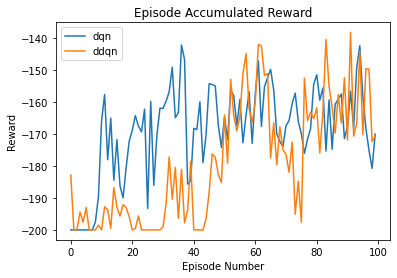

In [ ]:
import matplotlib.pyplot as plt

NUMBER_EPISODES = 1000

# Average results every N timesteps for better visualization.
average_range = 10
episode_ticks = int(NUMBER_EPISODES / average_range)

avg_rewards_dqn_agent_mount_car = np.array(rewards_dqn_agent_mount_car).reshape((episode_ticks, average_range))
avg_rewards_dqn_agent_mount_car = np.mean(avg_rewards_dqn_agent_mount_car, axis=1)

avg_rewards_ddqn_agent_mount_car = np.array(rewards_ddqn_agent_mount_car).reshape((episode_ticks, average_range))
avg_rewards_ddqn_agent_mount_car = np.mean(avg_rewards_ddqn_agent_mount_car, axis=1)


# Plot
plt.plot(range(episode_ticks), avg_rewards_dqn_agent_mount_car, label = 'dqn')
plt.plot(range(episode_ticks), avg_rewards_ddqn_agent_mount_car, label = 'ddqn')
plt.title("Episode Accumulated Reward")
plt.xlabel("Episode Number")
plt.ylabel("Reward")
plt.legend()
plt.show()